# Example 3: Energy Dispatch Problem - Risk Measures


**Problem structure.** 

A single generator commits a day-ahead schedule $g$ before the uncertain demand $\xi$ is revealed. In each scenario $s$, real-time imbalance is settled via curtailment (spillage, cheap) or load shedding (expensive):

$$\begin{align}
\min_{g,\, r^+_s,\, r^-_s} & \quad \rho\bigl[C_s(g, \xi)\bigr] \\
\quad \text{s.t.} & \quad g - r^+_s + r^-_s = d_s, \\
& \quad g \in [0, G_{\max}]
\end{align}$$
where the cost
$$
C_s = c_g \cdot g + c_{\text{spill}} \cdot r^+_s + c_{\text{shed}} \cdot r^-_s
$$

The four risk measures $\rho[\cdot]$ and their properties:

| Measure | Objective | Solver | Key property |
|---|---|---|---|
| Mean | $\mathbb{E}[C]$ | GLPK (LP) | Risk-neutral; ignores tail events |
| CVaR$_\alpha$ | $\eta + \frac{1}{1-\alpha}\sum_s p_s [C_s - \eta]_+$ | GLPK (LP) | Convex; averages worst $(1-\alpha)$ fraction |
| Mean–Variance | $\mathbb{E}[C] + \lambda \operatorname{Var}[C]$ | IPOPT (QP) | Markowitz-style; penalises spread symmetrically |
| Exponential | $\frac{1}{\theta}\log\mathbb{E}[e^{\theta C}]$ | IPOPT (NLP) | Entropic / CARA utility; $\theta \to 0$ recovers mean |

Optimization results will be compared for these risk measures.


## Model explanation

### Decision variables

| Variable | Type | Description |
|---|---|---|
| $g$ | continuous, $[0, G_{\max}]$ | Generation scheduled day-ahead (MW). This is the only first-stage decision — it must be fixed before demand is known. |
| $r^+_s$ | continuous, $\geq 0$ | Spillage (curtailment) in scenario $s$ (MW). Excess generation that must be wasted when supply exceeds demand. |
| $r^-_s$ | continuous, $\geq 0$ | Load shedding in scenario $s$ (MW). Unmet demand when supply falls short. |
| $\eta$ | continuous, free | CVaR formulation only. The Value-at-Risk threshold — the $\alpha$-quantile of the cost distribution, optimised jointly with the schedule. |
| $u_s$ | continuous, $\geq 0$ | CVaR formulation only. The excess of scenario cost above $\eta$, i.e. $u_s = [C_s - \eta]_+$. |

### Parameters (fixed inputs)

| Symbol | Value | Description |
|---|---|---|
| $G_{\max}$ | 150 MW | Generator capacity ceiling |
| $c_g$ | \$30/MWh | Day-ahead scheduling cost — paid regardless of what demand turns out to be |
| $c_{\text{spill}}$ | \$5/MWh | Curtailment penalty — cheap, reflects minor grid balancing cost |
| $c_{\text{shed}}$ | \$200/MWh | Value of lost load (VOLL) — very expensive, reflects societal cost of blackouts |
| $d_s$ | random | Realised demand in scenario $s$ (MW), drawn from $\mathcal{N}(100, 25^2)$ |
| $p_s$ | $1/N$ | Probability of scenario $s$; here all scenarios are equiprobable |
| $\alpha$ | 0.90 | Confidence level for VaR and CVaR |
| $\lambda$ | 0.05 | Risk-aversion weight in the mean–variance formulation |
| $\theta$ | 0.005 | Risk-aversion coefficient in the exponential formulation |

---

### The energy balance constraint

$$g - r^+_s + r^-_s = d_s \qquad \forall s$$

This is the _physical power balance_ in scenario $s$. It says that whatever the generator commits ($g$), the real-time shortfall or surplus must be exactly covered. Reading left to right: the net supply delivered to the grid equals the scheduled generation minus any curtailed excess, plus any emergency load shedding used to paper over a deficit. The equality is strict — power systems must be balanced instantaneously, there is no storage here. Because $g$ is fixed before $d_s$ is revealed, the two recourse variables $r^+_s$ and $r^-_s$ absorb all uncertainty: if $g > d_s$ the generator spills, if $g < d_s$ the system sheds load.

---

### The scenario cost

Before writing the objectives it helps to name the per-scenario cost:

$$C_s(g) = \underbrace{c_g \cdot g}_{\text{scheduling}} + \underbrace{c_{\text{spill}} \cdot r^+_s}_{\text{curtailment}} + \underbrace{c_{\text{shed}} \cdot r^-_s}_{\text{load shedding}}$$

The first term is paid upfront and is the same in every scenario. The second and third terms are _recourse costs_ — they depend on how badly the committed schedule mismatches realised demand. Because $c_{\text{shed}} \gg c_g \gg c_{\text{spill}}$, the model strongly prefers over-scheduling (cheap spillage) over under-scheduling (expensive blackouts), so any risk-averse formulation will push $g^*$ above the mean demand.

---

### The four objective functions

**Mean (risk-neutral)**

$$\min_g \; \mathbb{E}[C] = \sum_s p_s \, C_s$$

Minimises the probability-weighted average cost across all scenarios. This ignores the shape of the cost distribution entirely — a policy with a catastrophically expensive tail but a low average looks identical to a smooth, low-variance policy. It gives the lowest expected cost but leaves the system exposed to worst-case outcomes.

---

**CVaR (Conditional Value-at-Risk)**

$$\min_{g,\, \eta,\, u_s} \; \eta + \frac{1}{1-\alpha} \sum_s p_s \, u_s \qquad \text{s.t.} \quad u_s \geq C_s - \eta$$

$\eta$ is the VaR threshold — the cost level that is exceeded only with probability $1-\alpha$. The auxiliary variables $u_s$ capture how far each scenario's cost exceeds $\eta$; the constraint $u_s \geq C_s - \eta$ (combined with $u_s \geq 0$) means $u_s = \max(C_s - \eta, 0)$. The objective is then exactly the average cost in the worst $(1-\alpha)$ fraction of scenarios. This is the **Rockafellar–Uryasev linearisation** — it turns what would be a non-convex quantile problem into a linear programme. CVaR is the most popular risk measure in energy systems because it is convex, coherent, and directly interpretable.

---

**Mean–Variance**

$$\min_g \; \mathbb{E}[C] + \lambda \operatorname{Var}[C]$$

where $\operatorname{Var}[C] = \mathbb{E}[C^2] - (\mathbb{E}[C])^2$. The scalar $\lambda$ controls the trade-off: $\lambda = 0$ recovers the risk-neutral mean, while large $\lambda$ increasingly penalises spread. The quadratic term makes this a nonlinear programme. A key limitation is that variance penalises upside and downside deviations symmetrically — a lucky low-demand scenario that saves money is penalised just as much as a costly high-demand one.

---

**Exponential (Entropic risk measure)**

$$\min_g \; \frac{1}{\theta} \log \mathbb{E}\!\left[e^{\,\theta C}\right] = \frac{1}{\theta} \log \sum_s p_s \, e^{\,\theta C_s}$$

This is the certainty equivalent of an agent with constant absolute risk aversion (CARA) and utility $U(c) = -e^{-\theta c}$. The parameter $\theta > 0$ controls the degree of risk aversion — larger $\theta$ amplifies the contribution of high-cost scenarios exponentially, making the optimiser extremely conservative about tails. As $\theta \to 0$, a Taylor expansion shows the objective converges to $\mathbb{E}[C]$, recovering the risk-neutral case. This is the most nonlinear of the four formulations and requires a general NLP solver.



──────────────────────────────────────────────────────────────────────────────────────────
  Risk Measure      g* (MW)      E[C]      Std     VaR₉₀    CVaR₉₀   Entropic  Status
──────────────────────────────────────────────────────────────────────────────────────────
  Mean               116.19    4122.4   1411.8    4681.6    8272.5     8771.2  optimal
  CVaR               144.31    4588.4    112.3    4728.9    4762.0     4618.6  optimal
  Mean-Variance      144.12    4702.9     24.8    4726.0    4773.4     4704.6  optimal
  Exponential        142.83    4544.3    130.3    4681.0    4794.2     4595.5  optimal
──────────────────────────────────────────────────────────────────────────────────────────



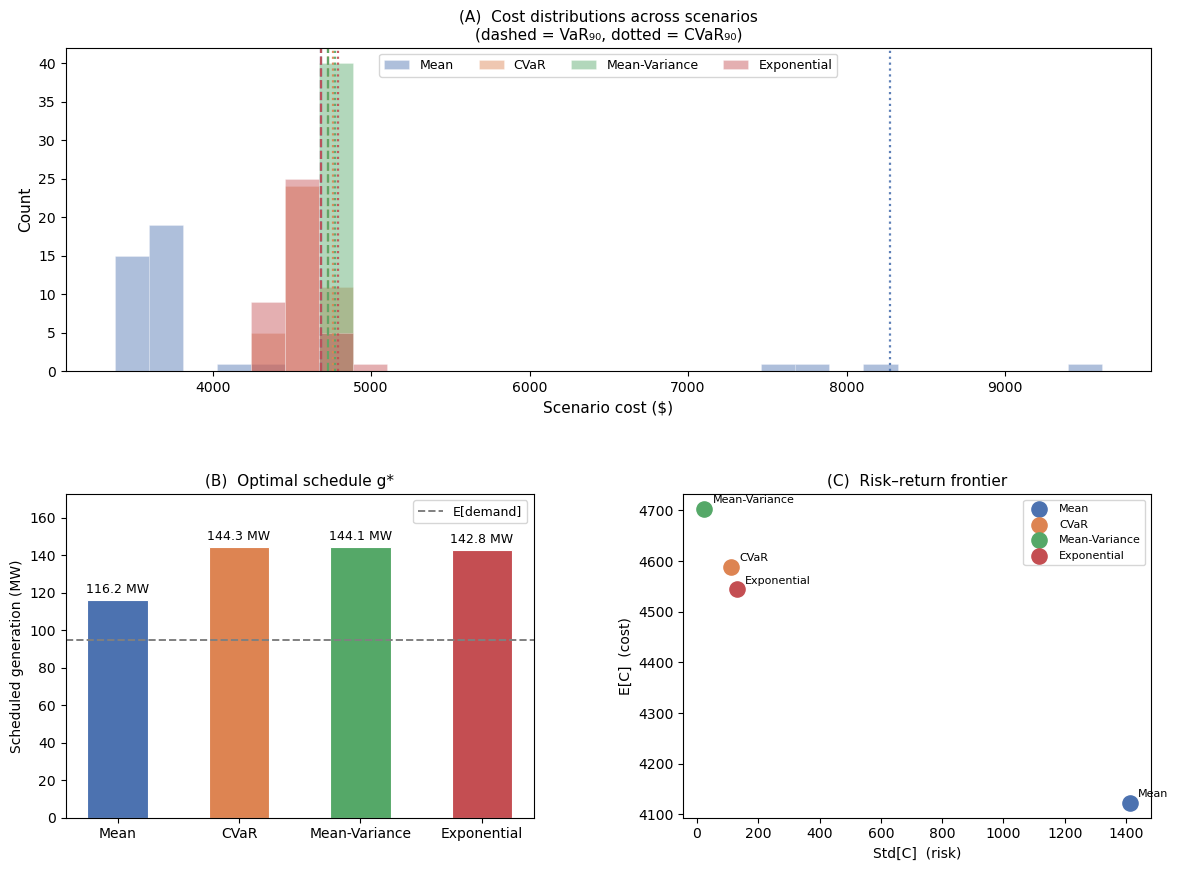


Figure saved to stochastic_dispatch.png


In [1]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# ─────────────────────────────────────────────────────────────────────────────
#  Problem parameters
# ─────────────────────────────────────────────────────────────────────────────
np.random.seed(42)

G_MAX   = 150.0   # MW,    generator capacity
C_GEN   =  30.0   # $/MWh, day-ahead scheduling cost
C_SPILL =   5.0   # $/MWh, over-generation curtailment penalty
C_SHED  = 200.0   # $/MWh, load-shedding penalty (VOLL)

ALPHA = 0.90    # confidence level for VaR / CVaR
LAM   = 0.05    # mean–variance risk-aversion weight  (λ)
THETA = 0.005   # exponential risk-aversion coefficient (θ)

# ─────────────────────────────────────────────────────────────────────────────
#  Scenarios: uncertain demand  ξ ~ N(100, 25²) clipped to [20, 160] MW
# ─────────────────────────────────────────────────────────────────────────────
N     = 40
d     = np.clip(np.random.normal(100, 25, N), 20, 160)  # demand realisations
p     = np.ones(N) / N                                  # equiprobable
S     = range(N)

# ─────────────────────────────────────────────────────────────────────────────
#  Helper: compute risk statistics from a scenario cost vector
# ─────────────────────────────────────────────────────────────────────────────
def risk_stats(costs):
    mean  = float(np.dot(p, costs))
    var   = float(np.dot(p, (costs - mean) ** 2))
    VaR   = float(np.quantile(costs, ALPHA))
    CVaR  = float(np.mean(costs[costs >= VaR]))
    entro = float((1/THETA) * np.log(np.dot(p, np.exp(THETA * costs))))
    return dict(mean=mean, variance=var, std=np.sqrt(var), VaR=VaR,
                CVaR=CVaR, entropic=entro)

# ─────────────────────────────────────────────────────────────────────────────
#  Model builder
#
#  Two-stage structure
#  ─────────────────
#  Stage 1 (day-ahead): schedule generation  g  [MW]
#  Stage 2 (real-time): observe demand  d_s; settle imbalance
#      spill_s  = excess generation curtailed  [MW]
#      shed_s   = unmet demand (load shed)     [MW]
#
#  Energy balance:  g - spill_s + shed_s = d_s   ∀s
#
#  Scenario cost:  C_s = c_g · g + c_spill · spill_s + c_shed · shed_s
# ─────────────────────────────────────────────────────────────────────────────
def build_and_solve(risk_measure: str):

    m = pyo.ConcreteModel(name=risk_measure)

    # ── Decision variables ────────────────────────────────────────────────────
    m.g     = pyo.Var(domain=pyo.NonNegativeReals, bounds=(0, G_MAX))
    m.spill = pyo.Var(S, domain=pyo.NonNegativeReals)
    m.shed  = pyo.Var(S, domain=pyo.NonNegativeReals)

    # ── Scenario cost expression ──────────────────────────────────────────────
    @m.Expression(S)
    def C(m, s):
        return C_GEN * m.g + C_SPILL * m.spill[s] + C_SHED * m.shed[s]

    # ── Energy balance (per scenario) ─────────────────────────────────────────
    @m.Constraint(S)
    def balance(m, s):
        return m.g - m.spill[s] + m.shed[s] == d[s]

    # ── Risk-measure objective ────────────────────────────────────────────────

    if risk_measure == 'Mean':
        # ── E[C] ──────────────────────────────────────────────────────────────
        m.obj = pyo.Objective(
            expr=sum(p[s] * m.C[s] for s in S),
            sense=pyo.minimize)
        slvr = pyo.SolverFactory('glpk')

    elif risk_measure == 'CVaR':
        # ── CVaR_α  (Rockafellar–Uryasev, 2000) ──────────────────────────────
        # CVaR = η + 1/(1−α) · Σ_s p_s · [C_s − η]₊
        m.eta = pyo.Var()                              # α-VaR threshold
        m.u   = pyo.Var(S, domain=pyo.NonNegativeReals)  # excess above η
        @m.Constraint(S)
        def cvar_cut(m, s):
            return m.u[s] >= m.C[s] - m.eta
        m.obj = pyo.Objective(
            expr=m.eta + (1/(1-ALPHA)) * sum(p[s] * m.u[s] for s in S),
            sense=pyo.minimize)
        slvr = pyo.SolverFactory('glpk')

    elif risk_measure == 'Mean-Variance':
        # ── E[C] + λ · Var[C] ────────────────────────────────────────────────
        # Var[C] = E[C²] − (E[C])²  (nonlinear → ipopt)
        m.mu = pyo.Expression(expr=sum(p[s] * m.C[s] for s in S))
        m.obj = pyo.Objective(
            expr=m.mu + LAM * (sum(p[s] * m.C[s]**2 for s in S) - m.mu**2),
            sense=pyo.minimize)
        slvr = pyo.SolverFactory('ipopt')

    elif risk_measure == 'Exponential':
        # ── Entropic risk measure: (1/θ) · log E[exp(θ C)] ───────────────────
        # = certainty equivalent under exponential utility  U(c) = −exp(−θ c)
        m.obj = pyo.Objective(
            expr=(1/THETA) * pyo.log(
                sum(p[s] * pyo.exp(THETA * m.C[s]) for s in S)),
            sense=pyo.minimize)
        slvr = pyo.SolverFactory('ipopt')

    else:
        raise ValueError(f"Unknown risk measure: {risk_measure}")

    # ── Solve ─────────────────────────────────────────────────────────────────
    res   = slvr.solve(m, tee=False)
    g_opt = float(pyo.value(m.g))
    costs = np.array([float(pyo.value(m.C[s])) for s in S])
    tc    = res.solver.termination_condition
    return g_opt, costs, tc

# ─────────────────────────────────────────────────────────────────────────────
#  Solve all four formulations
# ─────────────────────────────────────────────────────────────────────────────
risk_measures = ['Mean', 'CVaR', 'Mean-Variance', 'Exponential']
results = {}

print(f"\n{'─'*90}")
print(f"  {'Risk Measure':15s}  {'g* (MW)':>8}  {'E[C]':>8}  "
      f"{'Std':>7}  {'VaR₉₀':>8}  {'CVaR₉₀':>8}  {'Entropic':>9}  Status")
print(f"{'─'*90}")

for rm in risk_measures:
    g_opt, costs, status = build_and_solve(rm)
    stats = risk_stats(costs)
    results[rm] = dict(g_opt=g_opt, costs=costs, **stats)
    print(f"  {rm:15s}  {g_opt:8.2f}  {stats['mean']:8.1f}  "
          f"{stats['std']:7.1f}  {stats['VaR']:8.1f}  {stats['CVaR']:8.1f}  "
          f"{stats['entropic']:9.1f}  {status}")

print(f"{'─'*90}\n")

# ─────────────────────────────────────────────────────────────────────────────
#  Summary table
# ─────────────────────────────────────────────────────────────────────────────
df = pd.DataFrame({
    rm: {
        'Schedule g* (MW)' : results[rm]['g_opt'],
        'E[C] ($)'         : results[rm]['mean'],
        'Std[C] ($)'       : results[rm]['std'],
        f'VaR_{ALPHA} ($)' : results[rm]['VaR'],
        f'CVaR_{ALPHA} ($)': results[rm]['CVaR'],
        'Entropic ($)'     : results[rm]['entropic'],
    }
    for rm in risk_measures
}).T.round(1)

#print("Summary table")
#print(df.to_string())
#print(f"\n{'═'*90}\n\n")

# ─────────────────────────────────────────────────────────────────────────────
#  Plots
# ─────────────────────────────────────────────────────────────────────────────
colours = {'Mean': '#4C72B0', 'CVaR': '#DD8452',
           'Mean-Variance': '#55A868', 'Exponential': '#C44E52'}

fig = plt.figure(figsize=(14, 10))
#fig.suptitle('Stochastic Economic Dispatch — Risk Measure Comparison',
#             fontsize=14, fontweight='bold', y=0.98)
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.38, wspace=0.32)

# ── (A) Cost distributions ────────────────────────────────────────────────────
ax0 = fig.add_subplot(gs[0, :])
bins = np.linspace(
    min(r['costs'].min() for r in results.values()) - 100,
    max(r['costs'].max() for r in results.values()) + 100, 30)

for rm in risk_measures:
    ax0.hist(results[rm]['costs'], bins=bins, alpha=0.45,
             color=colours[rm], label=rm, edgecolor='white', linewidth=0.4)
    ax0.axvline(results[rm]['VaR'],  color=colours[rm], lw=1.6,
                linestyle='--', alpha=0.9)
    ax0.axvline(results[rm]['CVaR'], color=colours[rm], lw=1.6,
                linestyle=':',  alpha=0.9)

ax0.set_xlabel('Scenario cost ($)', fontsize=11)
ax0.set_ylabel('Count', fontsize=11)
ax0.set_title('(A)  Cost distributions across scenarios\n'
              '(dashed = VaR₉₀, dotted = CVaR₉₀)', fontsize=11)
ax0.legend(fontsize=9, ncol=4)

# ── (B) Scheduled output g* ───────────────────────────────────────────────────
ax1 = fig.add_subplot(gs[1, 0])
bars = ax1.bar(risk_measures,
               [results[rm]['g_opt'] for rm in risk_measures],
               color=[colours[rm] for rm in risk_measures],
               edgecolor='white', linewidth=0.8, width=0.5)
ax1.axhline(d.mean(), color='grey', lw=1.4, linestyle='--', label='E[demand]')
ax1.bar_label(bars, fmt='%.1f MW', padding=3, fontsize=9)
ax1.set_ylabel('Scheduled generation (MW)', fontsize=10)
ax1.set_title('(B)  Optimal schedule g*', fontsize=11)
ax1.set_ylim(0, G_MAX * 1.15)
ax1.legend(fontsize=9)

# ── (C) Risk–return trade-off ─────────────────────────────────────────────────
ax2 = fig.add_subplot(gs[1, 1])
for rm in risk_measures:
    ax2.scatter(results[rm]['std'], results[rm]['mean'],
                s=120, color=colours[rm], zorder=5, label=rm)
    ax2.annotate(rm, (results[rm]['std'], results[rm]['mean']),
                 textcoords='offset points', xytext=(6, 4), fontsize=8)
ax2.set_xlabel('Std[C]  (risk)', fontsize=10)
ax2.set_ylabel('E[C]  (cost)', fontsize=10)
ax2.set_title('(C)  Risk–return frontier', fontsize=11)
ax2.legend(fontsize=8)

plt.savefig('stochastic_dispatch.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nFigure saved to stochastic_dispatch.png")

## Conclusions

The key observation in the output is that more risk-averse measures push $g^*$ above the mean demand — they are willing to over-schedule (cheap spillage) to avoid the catastrophic load-shedding penalty in high-demand scenarios.

Note also that the mean (risk-neutral) solutions have very high variability, whereas the other measures are well-grouped around a mean cost of approximately $4500. 